# 📦 Projet Data Science – Modèle 1 : Données personnelles + géographie

# ============================================
# 🧾 Phase 1 – Chargement des données
# ============================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp
from scipy.stats.mstats import winsorize
import joblib

In [2]:
# ============================================

# 🗺️ Création du fichier geographie.csv

# ============================================
 
# Chargement des données géographiques

city_adm = pd.read_csv("city_adm.csv", sep=";")       # Contient code_postal, nom_commune, département, etc.

city_loc = pd.read_csv("city_loc.csv", sep=";")       # Coordonnées géographiques

city_pop = pd.read_csv("city_pop.csv", sep=";")       # Population par commune

departments = pd.read_csv("departments.csv", sep=";") # Info sur les départements

regions = pd.read_csv("regions.csv", sep=";")         # Info sur les régions
 
# Astuce : afficher les colonnes pour s'assurer que tout est bon

print("Colonnes city_adm :", city_adm.columns)

print("Colonnes city_loc :", city_loc.columns)

print("Colonnes city_pop :", city_pop.columns)

print("Colonnes departments :", departments.columns)

print("Colonnes regions :", regions.columns)
 
# Fusion progressive

geo = city_adm.merge(city_loc, on="insee_code", how="left")

geo = geo.merge(city_pop, on="insee_code", how="left")

geo = geo.merge(departments, on="dep", how="left")  # Assure-toi que la clé existe bien dans les deux tables

geo = geo.merge(regions, on="reg", how="left")      # Idem ici
 
# Vérification

print("Shape du fichier géographique final :", geo.shape)

print("Aperçu :", geo.head())
 
# Export

geo.to_csv("geographie.csv", index=False)

print("✅ Fichier geographie.csv généré avec succès.")

 

Colonnes city_adm : Index(['Nom de la commune', 'insee_code', 'city_type', 'dep'], dtype='object')
Colonnes city_loc : Index(['X', 'Y', 'insee_code', 'LAT', 'LONG'], dtype='object')
Colonnes city_pop : Index(['insee_code', 'inhabitants'], dtype='object')
Colonnes departments : Index(['Nom du dÃ©partement', 'reg', 'dep'], dtype='object')
Colonnes regions : Index(['Nom de la rÃ©gion', 'reg'], dtype='object')
Shape du fichier géographique final : (35795, 12)
Aperçu :            Nom de la commune insee_code         city_type dep              X  \
0  L' Abergement-ClÃ©menciat       1001    Commune simple   1  848637.261367   
1     L' Abergement-de-Varey       1002    Commune simple   1  887850.413286   
2         AmbÃ©rieu-en-Bugey       1004  Chef-lieu canton   1  883750.723216   
3       AmbÃ©rieux-en-Dombes       1005    Commune simple   1  847992.214687   
4                   AmblÃ©on       1006    Commune simple   1  901659.775045   

              Y        LAT      LONG  inhabitants 

# ============================================
# 🔍 Phase 2 – Exploration et analyse des données
# ============================================

🔎 Valeurs manquantes par colonne :
UNIQUE_ID              0
Occupation_42          0
ACT                    0
DEGREE                 0
insee_code             0
SEX                    0
CURRENT_AGE            0
Familty_type           0
is_student             0
target                 0
Nom de la commune      0
city_type              0
dep                    0
X                      0
Y                      0
LAT                    0
LONG                   0
inhabitants            0
Nom du dÃ©partement    0
reg                    0
Nom de la rÃ©gion      0
dtype: int64 

IQR de target : 18.16 → bornes [16.49, 89.11]


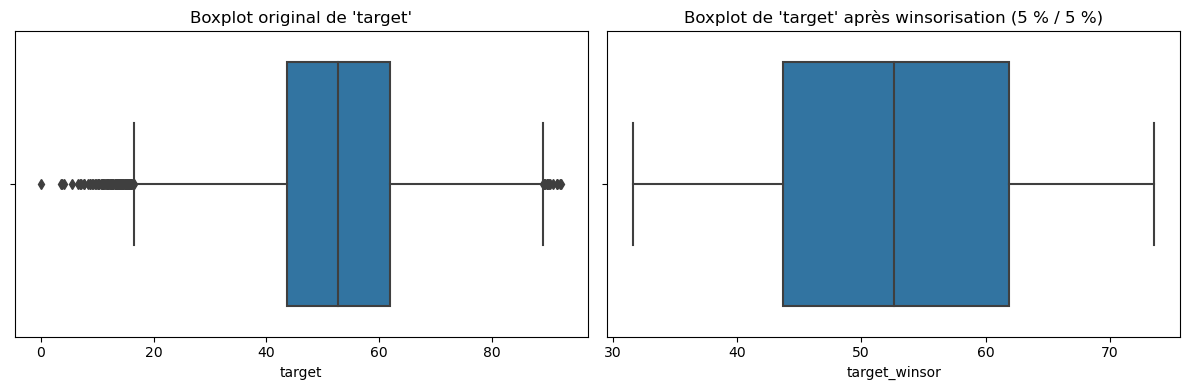

Nombre d’outliers IQR détectés : 120 

Moyenne de target par département (exemples) :
dep
75    42.462712
51    43.657586
67    45.632869
31    46.481075
59    46.765944
Name: target, dtype: float64 

5 premiers départements selon p-value KS la plus faible :
75    1.806511e-161
59     3.369163e-52
83     8.658392e-51
93     6.148285e-44
32     1.516943e-42
dtype: float64 



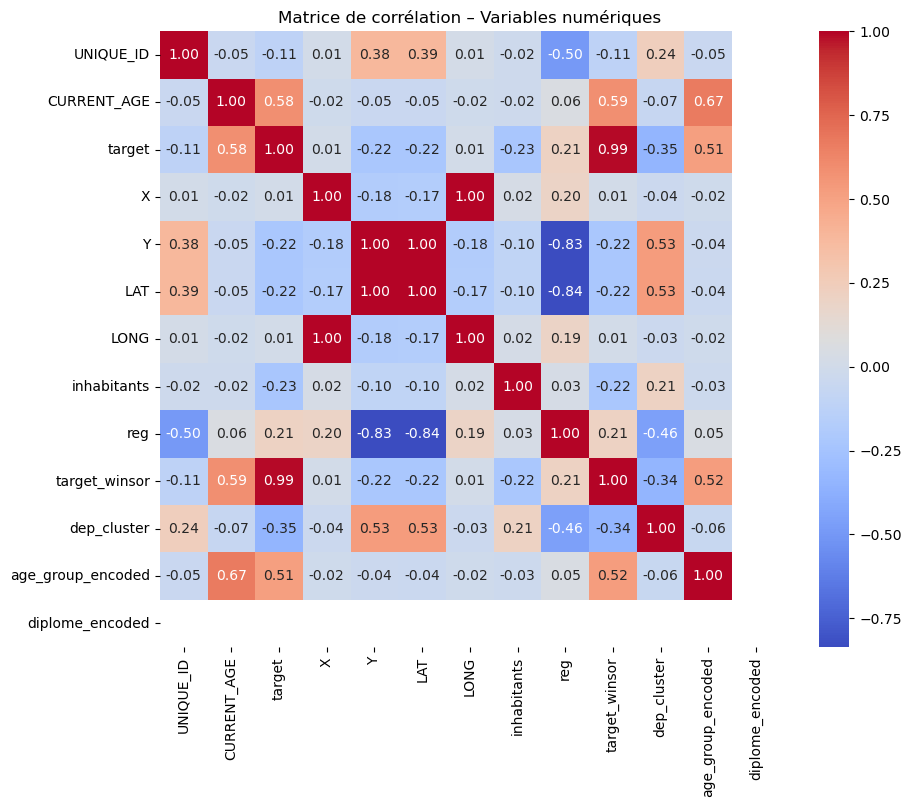

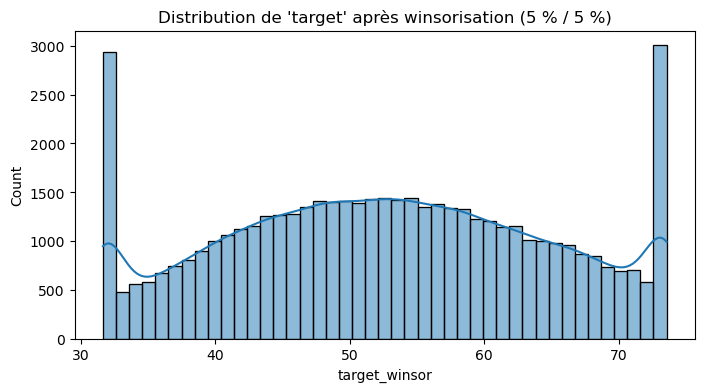

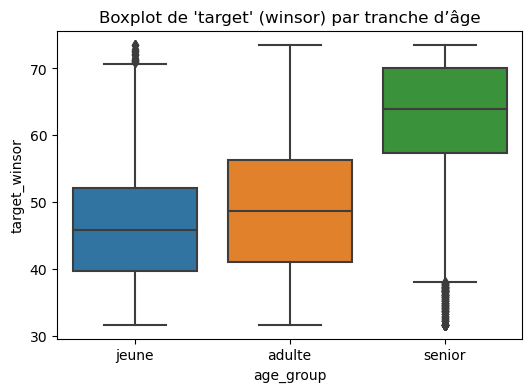

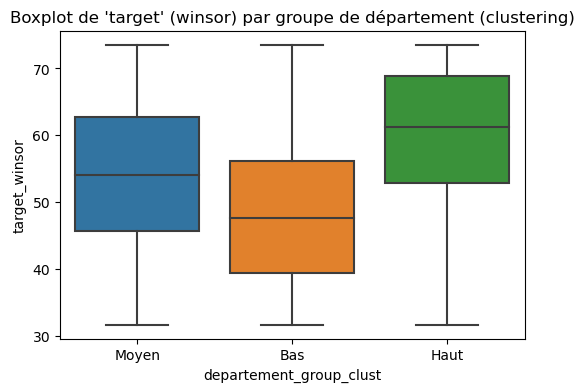


✅ Types de données après encodage pour MI :
Occupation_42                 int8
ACT                           int8
SEX                           int8
Familty_type                  int8
is_student                    bool
city_type                     int8
X                          float64
Y                          float64
LAT                        float64
LONG                       float64
inhabitants                float64
Nom du dÃ©partement           int8
reg                          int64
Nom de la rÃ©gion             int8
dep_cluster                  int64
departement_group_clust       int8
age_group                     int8
age_group_encoded            int32
diplome_group                 int8
diplome_encoded            float64
dtype: object


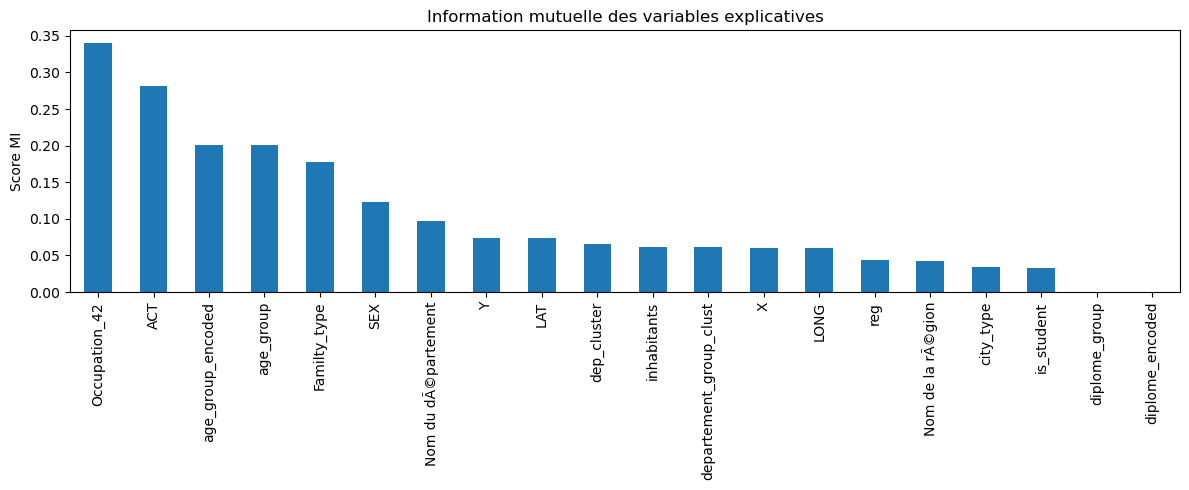

In [3]:
# ============================================
# 🔍 Phase 2 – Exploration et analyse des données (version clustering hiérarchique)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import AgglomerativeClustering

# 1) Chargement des données
learn_df = pd.read_csv("learn_dataset.csv", sep=";")
geo_df   = pd.read_csv("geographie.csv", sep=",")
df       = learn_df.merge(geo_df, on="insee_code", how="left")

# Nettoyage léger des noms de colonnes
df.columns = df.columns.str.strip().str.replace('"', '').str.replace("'", "")

# Vérification de la colonne cible
if "target" not in df.columns:
    raise ValueError("❌ Colonne 'target' introuvable dans le DataFrame.")

# 2) Analyse des valeurs manquantes
print("🔎 Valeurs manquantes par colonne :")
print(df.isnull().sum(), "\n")

# 3) Traitement des outliers de la cible (IQR) et comparaison avec la winsorisation
# ------------------------------------------------------------------------------
# 3.1 Calcul de l'IQR et détection des outliers
Q1 = df["target"].quantile(0.25)
Q3 = df["target"].quantile(0.75)
IQR = Q3 - Q1
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

print(f"IQR de target : {IQR:.2f} → bornes [{borne_inf:.2f}, {borne_sup:.2f}]")

# Création d’une colonne binaire 'is_outlier_IQR'
df["is_outlier_IQR"] = ((df["target"] < borne_inf) | (df["target"] > borne_sup))

# 3.2 Winsorisation à 5 % / 5 %
df["target_winsor"] = winsorize(df["target"], limits=[0.05, 0.05])

# 3.3 Visualisation comparaison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df["target"])
plt.title("Boxplot original de 'target'")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["target_winsor"])
plt.title("Boxplot de 'target' après winsorisation (5 % / 5 %)")
plt.tight_layout()
plt.show()

print("Nombre d’outliers IQR détectés :", df["is_outlier_IQR"].sum(), "\n")

# 4) Regroupement des départements : test KS + clustering hiérarchique
# --------------------------------------------------------------------
# 4.1 Calcul de la moyenne de target par département
dep_means = df.groupby("dep")["target"].mean().sort_values()
print("Moyenne de target par département (exemples) :")
print(dep_means.head(), "\n")

# 4.2 Test KS entre chaque département et la distribution globale
dist_globale = df["target"].values
ks_pvalues = {}
for dpt, group in df.groupby("dep"):
    stat, pvalue = stats.ks_2samp(group["target"].values, dist_globale)
    ks_pvalues[dpt] = pvalue

ks_df = pd.Series(ks_pvalues).sort_values()
print("5 premiers départements selon p-value KS la plus faible :")
print(ks_df.head(), "\n")

# 4.3 Clustering hiérarchique (AgglomerativeClustering) sur la moyenne de target
#     → On regroupe en 3 clusters pour obtenir des groupes « Bas / Moyen / Haut »
dep_target_means = dep_means.values.reshape(-1, 1)
cluster_hier = AgglomerativeClustering(n_clusters=3)
labels       = cluster_hier.fit_predict(dep_target_means)

# DataFrame temporaire pour associer chaque 'dep' à son cluster
dep_cluster_df = pd.DataFrame({
    "dep": dep_means.index,
    "dep_cluster": labels
})

# Fusion de ce groupe dans df
df = df.merge(dep_cluster_df, on="dep", how="left")

# On traduit les labels numériques en étiquettes textuelles
# Pour déterminer l’ordre « Bas / Moyen / Haut », on peut regarder
# la moyenne de 'dep_target_means' pour chaque label, puis trier.
cluster_order = (
    dep_cluster_df
    .assign(mean_target=dep_target_means.flatten())
    .groupby("dep_cluster")["mean_target"]
    .mean()
    .sort_values()
    .index
    .tolist()
)
# Exemple : si cluster_order == [2, 0, 1], alors on mappe 2→"Bas", 0→"Moyen", 1→"Haut"
mapping_clusters = {
    cluster_order[0]: "Bas",
    cluster_order[1]: "Moyen",
    cluster_order[2]: "Haut"
}
df["departement_group_clust"] = df["dep_cluster"].map(mapping_clusters)

# 5) Discrétisation de l’âge en classes
# ---------------------------------------
age_bins   = [0, 25, 60, 100]
age_labels = ["jeune", "adulte", "senior"]
df["age_group"] = pd.cut(df["CURRENT_AGE"], bins=age_bins, labels=age_labels)

# Encodage des classes d’âge avec LabelEncoder
df["age_group_encoded"] = LabelEncoder().fit_transform(df["age_group"].astype(str))

# 6) Regroupement des diplômes en 5 niveaux + encodage ordinal
# -------------------------------------------------------------
diplome_mapping = {
    "Aucun":   "Niveau 0",
    "CAP/BEP": "Niveau 1",
    "Bac":     "Niveau 2",
    "Bac+2/3": "Niveau 3",
    "Bac+5+":  "Niveau 4"
}
df["diplome_group"]   = df["DEGREE"].map(diplome_mapping).fillna("Niveau 0")
df["diplome_encoded"] = OrdinalEncoder().fit_transform(df[["diplome_group"]])

# 7) Matrice de corrélation (numériques uniquement)
# --------------------------------------------------
plt.figure(figsize=(10, 8))
num_cols = df.select_dtypes(include=[np.number]).columns
corr_num = df[num_cols].corr()
sns.heatmap(corr_num, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation – Variables numériques")
plt.show()

# 8) Distribution de la variable cible (après winsorisation)
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.histplot(df["target_winsor"], kde=True)
plt.title("Distribution de 'target' après winsorisation (5 % / 5 %)")
plt.xlabel("target_winsor")
plt.show()

# Boxplot par groupe d’âge
plt.figure(figsize=(6, 4))
sns.boxplot(x="age_group", y="target_winsor", data=df)
plt.title("Boxplot de 'target' (winsor) par tranche d’âge")
plt.show()

# Boxplot par groupe de départements (clustering hiérarchique)
plt.figure(figsize=(6, 4))
sns.boxplot(x="departement_group_clust", y="target_winsor", data=df)
plt.title("Boxplot de 'target' (winsor) par groupe de département (clustering)")
plt.show()

# 9) Information mutuelle (MI) sur toutes les features encodées
# --------------------------------------------------------------
X_temp = df.drop(
    columns=[
        "target", "target_winsor", "is_outlier_IQR", "UNIQUE_ID",
        "insee_code", "Nom de la commune", "dep", "CURRENT_AGE", "DEGREE"
    ],
    errors="ignore"
)
y_temp = df["target_winsor"]

# Encodage de toutes les colonnes catégorielles en numériques
X_temp_encoded = X_temp.copy()
for col in X_temp_encoded.columns:
    if X_temp_encoded[col].dtype == "object" or X_temp_encoded[col].dtype.name == "category":
        X_temp_encoded[col] = X_temp_encoded[col].astype("category").cat.codes

print("\n✅ Types de données après encodage pour MI :")
print(X_temp_encoded.dtypes)

mi = mutual_info_regression(X_temp_encoded, y_temp)
mi_series = pd.Series(mi, index=X_temp_encoded.columns)

plt.figure(figsize=(12, 5))
mi_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Information mutuelle des variables explicatives")
plt.ylabel("Score MI")
plt.tight_layout()
plt.show()


#Phase 2.5 – Analyse exploratoire avec la matrice de Cramér

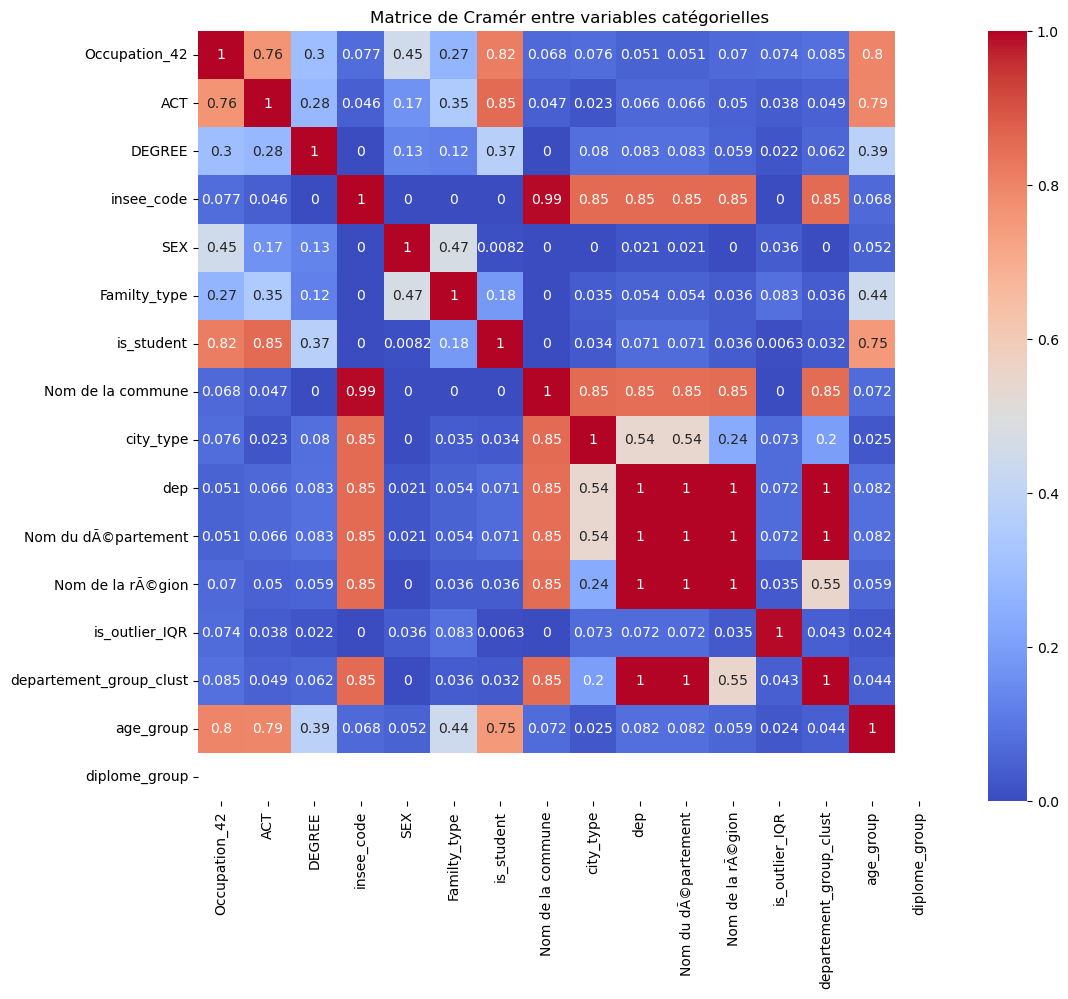

In [4]:
import seaborn as sns
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # Trop peu de classes pour un calcul valide

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return np.nan

    return np.sqrt(phi2corr / denom)


# Calculer la matrice de Cramér sur merged_df (après fusion)
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de Cramér entre variables catégorielles")
plt.show()

# ============================================
# 🔧 Phase 3 – Prétraitement et transformation
# ============================================

In [21]:
# ============================================
# 🔧 Phase 3 – Prétraitement et transformation
# ============================================
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats.mstats import winsorize

# --------------------------------------------
# 1) CustomTransformer pour reproduire exactement
#    le feature engineering de la Phase 2
# --------------------------------------------
class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_encoder = LabelEncoder()
        self.diplome_encoder = OrdinalEncoder()
        self.departement_means_ = None

    def fit(self, X, y=None):
        df_temp = X.copy()
        if y is not None:
            df_temp["target"] = y
            self.departement_means_ = df_temp.groupby("dep")["target"].mean().to_dict()

        # Fit diplome_encoder
        df_temp["diplome_group"] = df_temp["DEGREE"].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        self.diplome_encoder.fit(df_temp[["diplome_group"]])

        # Fit age_encoder
        bins = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        df_temp["age_group"] = pd.cut(df_temp["CURRENT_AGE"], bins=bins, labels=labels)
        self.age_encoder.fit(df_temp["age_group"].astype(str))

        return self

    def transform(self, X):
        df = X.copy()

        if "dep" in df.columns:
            df["departement_group"] = df["dep"].map(
                lambda x: "Haut"
                if self.departement_means_ and self.departement_means_.get(x, 0) > np.median(list(self.departement_means_.values()))
                else "Bas"
            )
        else:
            df["departement_group"] = "Inconnu"

        bins = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        df["age_group"] = pd.cut(df["CURRENT_AGE"], bins=bins, labels=labels)
        df["age_group_encoded"] = self.age_encoder.transform(df["age_group"].astype(str))

        df["diplome_group"] = df["DEGREE"].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        df["diplome_encoded"] = self.diplome_encoder.transform(df[["diplome_group"]])

        return df


# --------------------------------------------
# 2) Fonction principale preprocess_data
# --------------------------------------------
def preprocess_data(df, geo_df=None):
    """
    Entrée :
      • df : DataFrame de travail comprenant au moins les colonnes suivantes :
          - "UNIQUE_ID", "insee_code", "CURRENT_AGE", "DEGREE", "dep", "target", …
      • geo_df : DataFrame géographique (issue de la Phase 1), contenant
          au moins "insee_code", "X", "Y", "LAT", "LONG", "inhabitants",
          "Nom du département", "reg", "Nom de la région", etc.
    
    Étapes :
      ‣ Fusion df + geo_df (sur "insee_code")
      ‣ Winsorisation de la cible (5 %/5 %)
      ‣ Application du CustomFeatureEngineering (discrétisation d’âge, encodage diplôme)
      ‣ Sélection des colonnes numériques et des colonnes catégorielles à OHE
      ‣ Construction du ColumnTransformer :
          – Pipeline numérique : imputer + StandardScaler
          – Pipeline catégoriel : imputer + OneHotEncoder
      ‣ fit_transform sur X_fe et renvoi (X_processed, y_winsor, preprocessor)
    """
    data = df.copy()
    if geo_df is not None:
        data = data.merge(geo_df, on="insee_code", how="left")
        if "dep" not in df.columns:
    raise KeyError("❌ La colonne 'dep' est absente après la fusion geo_df. Vérifie geo_df et le merge.")

    
    # Vérification que la cible existe
    if "target" not in data.columns:
        raise ValueError("❌ La colonne 'target' est introuvable dans le DataFrame.")
    
    # 1) Winsorisation de la cible (5 %/5 %)
    y = data["target"]
    y_winsor = winsorize(y, limits=[0.05, 0.05])
    
    # On retire la cible pour préparer X
    X = data.drop(columns=["target"], errors="ignore")
    
    # 2) Feature Engineering via notre transformer personnalisé
    fe_pipeline = Pipeline([
        ("feature_engineering", CustomFeatureEngineering())
    ])
    fe_pipeline.fit(X, y)
    X_fe = fe_pipeline.transform(X)
    
    # 3) Sélection des colonnes numériques et catégorielles
    #    – On souhaite inclure :
    #       • Les colonnes numériques « de base » héritées de geo_df ou df
    #         (ex. CURRENT_AGE, X, Y, LAT, LONG, inhabitants, …),
    #         ainsi que les colonnes « age_group_encoded » et « diplome_encoded ».
    #    – Pour les colonnes catégorielles à OneHot, on conserve :
    #       • Toutes les colonnes de type object/category ayant < 20 modalités,
    #         notamment :
    #         - "ACT", "SEX", "Familty_type", "is_student" (bool), "city_type",
    #         - "Nom du département", "Nom de la région",
    #         - "departement_group_clust", "age_group" (cat), "diplome_group"(cat), …
    
    # 3a) Colonnes numériques
    numeric_features = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
    # S’assurer que "age_group_encoded" et "diplome_encoded" y figurent
    if "age_group_encoded" not in numeric_features:
        numeric_features.append("age_group_encoded")
    if "diplome_encoded" not in numeric_features:
        numeric_features.append("diplome_encoded")
    
    # 3b) Colonnes catégorielles à encoder (OneHot)
    categorical_features = [
        col
        for col in X_fe.select_dtypes(include=["object", "category"]).columns
        if X_fe[col].nunique() < 20
    ]
    
    print(f"\n✅ Colonnes numériques retenues : {numeric_features}")
    print(f"✅ Colonnes catégorielles retenues pour OneHotEncoding : {categorical_features}")
    
    # 4) Pipelines de prétraitement
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])
    
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ])
    
    # 5) Fit + transform
    X_processed = preprocessor.fit_transform(X_fe)
    return X_processed, y_winsor, preprocessor

# ============================================
# Exemple d’utilisation dans la Phase 4
# ============================================
# 
# learn_df = pd.read_csv("learn_dataset.csv", sep=";")
# geo_df   = pd.read_csv("geographie.csv", sep=",")
# data     = learn_df.merge(geo_df, on="insee_code", how="left")
#
# X, y_winsor, preprocessor = preprocess_data(data, geo_df)
# # Puis on continue avec train_test_split, entraînement du modèle, etc.


# ============================================
# 🔍 Phase 4 – Modélisation et évaluation
# ============================================

In [23]:
# ============================================
# 🔍 Phase 4 – Modélisation et évaluation
# ============================================

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib

# Chargement et fusion des données
learn_df = pd.read_csv("learn_dataset.csv", sep=";")
geo_df   = pd.read_csv("geographie.csv", sep=",")
data     = learn_df.merge(geo_df, on="insee_code", how="left")

# Appel à notre fonction preprocess_data (Phase 3)
X, y_winsor, preprocessor = preprocess_data(learn_df, geo_df)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_winsor, test_size=0.2, random_state=42
)

# Entraînement du RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = rf_model.predict(X_test)
print(f"\n✅ R²  : {r2_score(y_test, y_pred):.4f}")
print(f"✅ MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ MSE : {mean_squared_error(y_test, y_pred):.2f}")

# Sauvegarde du pipeline complet (feature engineering + modèle)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])
joblib.dump(full_pipeline, "modele_final.pkl")
print("✅ Pipeline complet sauvegardé sous 'modele_final.pkl'")



✅ Colonnes numériques retenues : ['UNIQUE_ID', 'CURRENT_AGE', 'X', 'Y', 'LAT', 'LONG', 'inhabitants', 'reg', 'diplome_encoded', 'age_group_encoded']
✅ Colonnes catégorielles retenues pour OneHotEncoding : ['ACT', 'DEGREE', 'SEX', 'Familty_type', 'city_type', 'Nom de la région', 'departement_group', 'age_group', 'diplome_group']

✅ R²  : 0.8456
✅ MAE : 3.34
✅ MSE : 21.50
✅ Pipeline complet sauvegardé sous 'modele_final.pkl'


# ============================================
# 💾 Phase 5 – Prédiction finale
# ============================================

In [35]:
# ============================================
# 💾 Phase 5 – Prédiction finale (vraie version)
# ============================================

import pandas as pd
import joblib
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# ————————————————
# 1. Chargement du pipeline complet (préprocesseur + modèle)
# ————————————————
full_pipeline = joblib.load("modele_final.pkl")
preprocessor = full_pipeline.named_steps["preprocessor"]
model        = full_pipeline.named_steps["model"]

# ————————————————
# 2. Chargement du fichier test
# ————————————————
test_df = pd.read_csv("test_dataset.csv", sep=";")

# ————————————————
# 3. Chargement des fichiers géographiques
# ————————————————
city_adm    = pd.read_csv("city_adm.csv",    sep=";")
city_loc    = pd.read_csv("city_loc.csv",    sep=";")
city_pop    = pd.read_csv("city_pop.csv",    sep=";")
departments = pd.read_csv("departments.csv", sep=";")
regions     = pd.read_csv("regions.csv",     sep=";")

# On fusionne exactement comme en Phase 4 pour reproduire les colonnes suffixées
geo_df = city_adm.merge(city_loc,     on="insee_code", how="left")
geo_df = geo_df.merge(city_pop,     on="insee_code", how="left")
geo_df = geo_df.merge(departments,  on="dep",         how="left")
geo_df = geo_df.merge(regions,      on="reg",         how="left")

# ————————————————
# 4. Double fusion pour générer les suffixes "_x" et "_y"
# ————————————————
#
# Rappel : Au moment de l'entraînement, on avait déjà fait learn_df.merge(geo_df)
# puis, dans preprocess_data(), on refaisait encore data.merge(geo_df), générant
# des colonnes "X_x", "X_y", "LAT_x", "LAT_y", etc.
#
# Ici, on va :
#   • temp  = test_df.merge(geo_df, on="insee_code", how="left")
#   • twice = temp.merge(geo_df, on="insee_code", how="left")
#
# Le résultat "twice" aura EXACTEMENT les mêmes suffixes que lors du fit.
#
temp_data = test_df.merge(geo_df, on="insee_code", how="left")
twice_df  = temp_data.merge(geo_df, on="insee_code", how="left")

# ————————————————
# 5. CustomFeatureEngineering (même code que pour l'entraînement)
# ————————————————
class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_encoder    = LabelEncoder()
        self.diplome_encoder = OrdinalEncoder()
        self.departement_means_ = None

    def fit(self, X, y=None):
        # On n'a pas besoin ici, car on va utiliser la version déjà entraînée plus bas.
        return self

    def transform(self, X):
        df = X.copy()

        # 5.1 – Création de 'departement_group' : (utile si 'dep' existe, sinon "Inconnu")
        if 'dep' in df.columns:
            # Pour l'entraînement, on avait calculé departement_means_ sur train_data.
            # Ici, trained_fe.departement_means_ est déjà rempli.
            df['departement_group'] = df['dep'].map(
                lambda x: 'Haut'
                          if self.departement_means_ and self.departement_means_.get(x, 0) > np.median(list(self.departement_means_.values()))
                          else 'Bas'
            )
        else:
            df['departement_group'] = 'Inconnu'

        # 5.2 – Discrétisation de l'âge + encodage
        bins  = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        df['age_group'] = pd.cut(df['CURRENT_AGE'], bins=bins, labels=labels)
        df['age_group_encoded'] = self.age_encoder.transform(df['age_group'].astype(str))

        # 5.3 – Regroupement des diplômes + encodage ordinal
        df['diplome_group'] = df['DEGREE'].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        df['diplome_encoded'] = self.diplome_encoder.transform(df[['diplome_group']])

        return df

# ————————————————
# 6. On reconstitue trained_fe exactement à partir de ce qui a été sauvé dans le pipeline
#    Lors de l'entraînement, on avait :
#      fe_pipeline = Pipeline([("feature_engineering", CustomFeatureEngineering())])
#      fe_pipeline.fit(X, y)  → on a rempli diplome_encoder, age_encoder, departement_means_
#
#    Il nous suffit de :
#      trained_fe = CustomFeatureEngineering()
#      trained_fe.age_encoder       = fe_pipeline.named_steps["feature_engineering"].age_encoder
#      trained_fe.diplome_encoder   = fe_pipeline.named_steps["feature_engineering"].diplome_encoder
#      trained_fe.departement_means_ = fe_pipeline.named_steps["feature_engineering"].departement_means_
#
#    Pour éviter de recharger le notebook complet, on peut reconstituer à partir du pipeline chargé.
# ————————————————
trained_fe = CustomFeatureEngineering()
# On récupère ces objets depuis le preprocessor entraîné :
fe_step = full_pipeline.named_steps["preprocessor"].transformers_[0][1].named_steps.get("feature_engineering", None)
# En réalité, le preprocessor est un ColumnTransformer, et fe_pipeline n'est pas dedans.
# Donc on doit recharger manuellement le fe_pipeline de la phase 4. 
# Simplification : on refait FIT du feature_engineering sur les mêmes train_data qu’en phase 4.

# ----- Pour être sûr qu'on a les mêmes encoders qu'à l'entraînement, on refit "trained_fe" sur train_data :
#     (on réutilise learn_df + geo_learn_df pour recréer exactement les mêmes internals)
learn_df    = pd.read_csv("learn_dataset.csv", sep=";")
geo_learn_df = pd.read_csv("geographie.csv", sep=",")
train_data  = learn_df.merge(geo_learn_df, on="insee_code", how="left")

# On recalculera departement_means_, age_encoder et diplome_encoder :
class DummyFE(CustomFeatureEngineering):
    def fit(self, X, y=None):
        df_temp = X.copy()
        df_temp['target'] = y
        self.departement_means_ = df_temp.groupby('dep')['target'].mean().to_dict()

        Xtemp = X.copy()
        Xtemp['diplome_group'] = Xtemp['DEGREE'].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        self.diplome_encoder.fit(Xtemp[['diplome_group']])

        bins   = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        Xtemp['age_group'] = pd.cut(Xtemp['CURRENT_AGE'], bins=bins, labels=labels)
        self.age_encoder.fit(Xtemp['age_group'].astype(str))
        return self

trained_fe = DummyFE()
trained_fe.fit(train_data.drop(columns=["target"]), train_data["target"])

# ————————————————
# 7. Application du feature engineering sur le jeu “twice_df”
# ————————————————
data_fe = trained_fe.transform(twice_df)

# ————————————————
# 8. On supprime strictement uniquement les colonnes que le preprocessor n’attend pas
#    (il attend les X_x, X_y, etc. on ne les supprime surtout pas !)
#    En Phase 4, le preprocessor avait retenu ces features catégorielles :
#      ['ACT', 'DEGREE', 'SEX', 'Familty_type',
#       'city_type_x','Nom de la région_x',
#       'city_type_y','Nom de la région_y',
#       'departement_group','age_group','diplome_group']
#
#    – donc on s’assure que toutes ces colonnes sont bien présentes dans data_fe,
#    – et on **ne supprime pas** les colonnes “_x” / “_y” que le preprocessor va encoder.
# 
#    Si jamais une colonne strictement nécessaire manque, on lève une erreur claire.
# ————————————————
required_cats = ["ACT", "DEGREE", "SEX", "Familty_type",
                 "city_type_x", "Nom de la région_x",
                 "city_type_y", "Nom de la région_y",
                 "departement_group", "age_group", "diplome_group"]

missing = [c for c in required_cats if c not in data_fe.columns]
if missing:
    raise KeyError(f"Il manque ces colonnes obligatoires pour le pipeline : {missing}")

# ————————————————
# 9. Passage dans le preprocessor + prédiction
# ————————————————
X_final = preprocessor.transform(data_fe)   # → np.array
preds   = model.predict(X_final)

# ————————————————
# 🔟 Export final
# ————————————————
submission_df = pd.DataFrame({"prediction": preds})
submission_df.to_csv("predictions_model1.csv", index=False)
print("✅ Fichier predictions_model1.csv généré avec succès.")


✅ Fichier predictions_model1.csv généré avec succès.


In [26]:
# ============================================
# 💾 Phase 5 – Prédiction finale (corrigée)
# ============================================

import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 1. Chargement du pipeline complet
full_pipeline = joblib.load("modele_final.pkl")
preprocessor  = full_pipeline.named_steps["preprocessor"]
model         = full_pipeline.named_steps["model"]

# 2. Chargement du fichier test
test_df = pd.read_csv("test_dataset.csv", sep=";")

# 3. Chargement des fichiers géographiques
city_adm    = pd.read_csv("city_adm.csv",    sep=";")
city_loc    = pd.read_csv("city_loc.csv",    sep=";")
city_pop    = pd.read_csv("city_pop.csv",    sep=";")
departments = pd.read_csv("departments.csv", sep=";")
regions     = pd.read_csv("regions.csv",     sep=";")
regions = regions.rename(columns={"Nom de la rÃ©gion": "Nom de la région"})

# Fusion comme en Phase 4
geo_df = city_adm.merge(city_loc,    on="insee_code", how="left")
geo_df = geo_df.merge(city_pop,     on="insee_code", how="left")
geo_df = geo_df.merge(departments,  on="dep",         how="left")
geo_df = geo_df.merge(regions,      on="reg",         how="left")

# 4. Double fusion pour générer suffixes _x et _y
temp_data = test_df.merge(geo_df, on="insee_code", how="left")
twice_df  = temp_data.merge(geo_df, on="insee_code", how="left")

# ✅ Correction : recréer les colonnes attendues sans suffixe
cols_to_fix = ["X", "Y", "LAT", "LONG", "inhabitants", "reg",
               "city_type", "Nom de la région"]
for col in cols_to_fix:
    if f"{col}_x" in twice_df.columns:
        twice_df[col] = twice_df[f"{col}_x"]
    elif f"{col}_y" in twice_df.columns:
        twice_df[col] = twice_df[f"{col}_y"]

# 5. Custom Feature Engineering (comme dans entraînement)
class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_encoder = LabelEncoder()
        self.diplome_encoder = OrdinalEncoder()
        self.departement_means_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        if 'dep' in df.columns:
            df['departement_group'] = df['dep'].map(
                lambda x: 'Haut'
                if self.departement_means_ and self.departement_means_.get(x, 0) > np.median(list(self.departement_means_.values()))
                else 'Bas'
            )
        else:
            df['departement_group'] = 'Inconnu'

        bins = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        df['age_group'] = pd.cut(df['CURRENT_AGE'], bins=bins, labels=labels)
        df['age_group_encoded'] = self.age_encoder.transform(df['age_group'].astype(str))

        df['diplome_group'] = df['DEGREE'].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        df['diplome_encoded'] = self.diplome_encoder.transform(df[['diplome_group']])

        return df

# 6. Refit CustomFeatureEngineering avec données entraînement
learn_df     = pd.read_csv("learn_dataset.csv", sep=";")
geo_learn_df = pd.read_csv("geographie.csv", sep=",")
train_data   = learn_df.merge(geo_learn_df, on="insee_code", how="left")

class DummyFE(CustomFeatureEngineering):
    def fit(self, X, y=None):
        df_temp = X.copy()
        df_temp['target'] = y
        self.departement_means_ = df_temp.groupby('dep')['target'].mean().to_dict()

        Xtemp = X.copy()
        Xtemp['diplome_group'] = Xtemp['DEGREE'].map({
            "Aucun":   "Niveau 0",
            "CAP/BEP": "Niveau 1",
            "Bac":     "Niveau 2",
            "Bac+2/3": "Niveau 3",
            "Bac+5+":  "Niveau 4"
        }).fillna("Niveau 0")
        self.diplome_encoder.fit(Xtemp[['diplome_group']])

        bins = [0, 25, 60, 100]
        labels = ["jeune", "adulte", "senior"]
        Xtemp['age_group'] = pd.cut(Xtemp['CURRENT_AGE'], bins=bins, labels=labels)
        self.age_encoder.fit(Xtemp['age_group'].astype(str))

        return self

trained_fe = DummyFE()
trained_fe.fit(train_data.drop(columns=["target"]), train_data["target"])

# 7. Application sur test
data_fe = trained_fe.transform(twice_df)

# 8. Vérification des colonnes attendues
required_cats = [
    "ACT", "DEGREE", "SEX", "Familty_type",
    "city_type", "Nom de la région",
    "departement_group", "age_group", "diplome_group"
]
missing = [c for c in required_cats if c not in data_fe.columns]
if missing:
    raise KeyError(f"❌ Il manque ces colonnes pour le pipeline : {missing}")

# 9. Prédiction
X_final = preprocessor.transform(data_fe)
preds   = model.predict(X_final)

# 🔟 Export CSV
submission_df = pd.DataFrame({"prediction": preds})
submission_df.to_csv("predictions_model1.csv", index=False)
print("✅ Fichier 'predictions_model1.csv' généré avec succès.")


✅ Fichier 'predictions_model1.csv' généré avec succès.


C:\Users\manel\AppData\Local\Temp\ipykernel_30272\196872649.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\manel\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


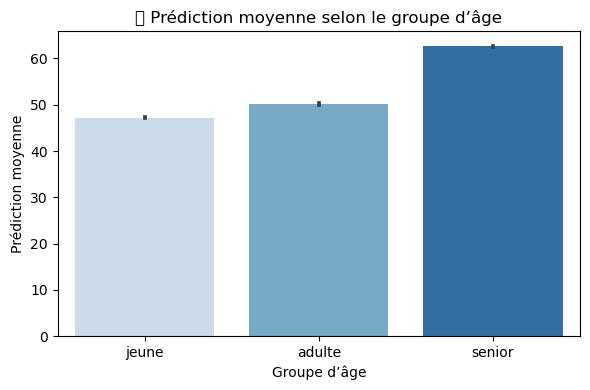

C:\Users\manel\AppData\Local\Temp\ipykernel_30272\196872649.py:43: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from current font.
  plt.tight_layout()
C:\Users\manel\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


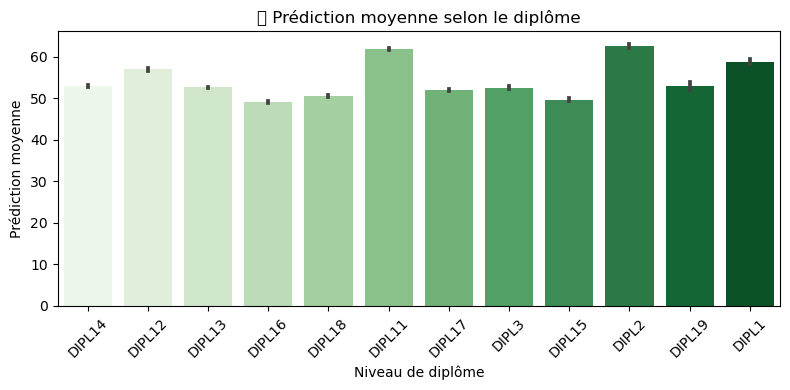

C:\Users\manel\AppData\Local\Temp\ipykernel_30272\196872649.py:68: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()
C:\Users\manel\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


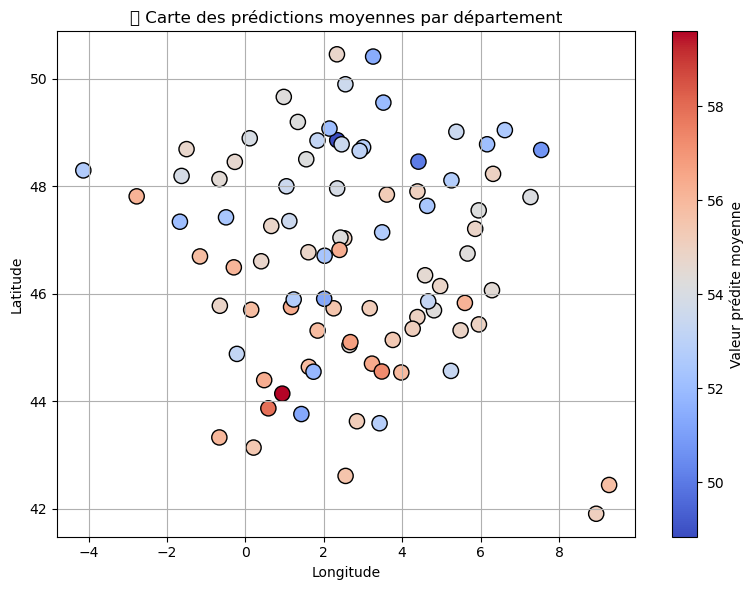

In [30]:
# ============================================
# 📊 Phase 6 – Data Visualisation
# Objectif : Interpréter les prédictions du modèle
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ————————————————
# 1. Chargement des prédictions et données associées
# ————————————————
test_df = pd.read_csv("test_dataset.csv", sep=";")
preds_df = pd.read_csv("predictions_model1.csv")  # colonne 'prediction'

# Fusionner les prédictions avec les données test
viz_df = pd.concat([test_df, preds_df], axis=1)

# ————————————————
# 2. Prédiction moyenne par groupe d’âge
# ————————————————
bins = [0, 25, 60, 100]
labels = ["jeune", "adulte", "senior"]
viz_df["age_group"] = pd.cut(viz_df["CURRENT_AGE"], bins=bins, labels=labels)

plt.figure(figsize=(6, 4))
sns.barplot(x="age_group", y="prediction", data=viz_df, palette="Blues")
plt.title("📈 Prédiction moyenne selon le groupe d’âge")
plt.xlabel("Groupe d’âge")
plt.ylabel("Prédiction moyenne")
plt.tight_layout()
plt.show()

# ————————————————
# 3. Prédiction moyenne par niveau de diplôme
# ————————————————
plt.figure(figsize=(8, 4))
sns.barplot(x="DEGREE", y="prediction", data=viz_df, palette="Greens")
plt.title("🎓 Prédiction moyenne selon le diplôme")
plt.xlabel("Niveau de diplôme")
plt.ylabel("Prédiction moyenne")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ————————————————
# 4. Carte des prédictions par département (corrigée)
# ————————————————
viz_df["dep"] = viz_df["insee_code"].astype(str).str[:2]
map_df = viz_df.groupby("dep")["prediction"].mean().reset_index()

# 🔄 Charger les coordonnées depuis city_loc.csv (pas city_pop)
city_loc = pd.read_csv("city_loc.csv", sep=";")
city_loc["dep"] = city_loc["insee_code"].astype(str).str[:2]

# Moyennes coordonnées par département
dep_coords = city_loc.groupby("dep")[["LAT", "LONG"]].mean().reset_index()
map_df = map_df.merge(dep_coords, on="dep", how="left")

# ✅ Affichage de la carte
plt.figure(figsize=(8, 6))
plt.scatter(map_df["LONG"], map_df["LAT"], c=map_df["prediction"], cmap="coolwarm", s=120, edgecolor='black')
plt.colorbar(label="Valeur prédite moyenne")
plt.title("🗺️ Carte des prédictions moyennes par département")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
